In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from networks import fcn_isotropic
import scipy
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

In [26]:
data = np.load(r'D:\Synthetic_data_pulse\param_fbh_size10mm_depth30pct_thickness6mm.npz', allow_pickle=True)

In [27]:
data['meta']

array([['time', '28/06/2025 02:56:27'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '600'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '634'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.006'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [3]:
# emissivity of the sample 
k=2 # W/(mK)
q=1600 # kg/m^3
Cp=700 # J/(kgK)

a=k/(q*Cp)
print(f'Thermal diffusivity value: {a} m2/s')

Thermal diffusivity value: 1.7857142857142857e-06 m2/s


In [4]:
data = np.array(data['data'], dtype=np.float32)
data=torch.from_numpy(data)
data.dtype

torch.float32

In [5]:
data.size()

torch.Size([634, 512, 512])

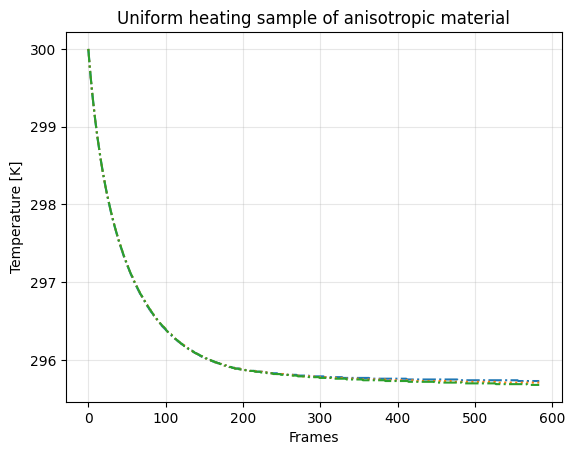

In [11]:
T,Y,X=data.shape
y_center=Y//2
x_center=X//2

plt.plot(data[50:,y_center,x_center]+273.15,linestyle='-.',label='Center point')
plt.plot(data[50:,y_center+100,x_center+100]+273.15,linestyle=':',label='Off-center point 1')
plt.plot(data[50:,y_center-200,x_center-200]+273.15,linestyle='-.',label='Off-center point 2')
plt.xlabel('Frames')
plt.ylabel('Temperature [K]')
plt.title('Uniform heating sample of anisotropic material')
plt.grid(alpha=0.3)


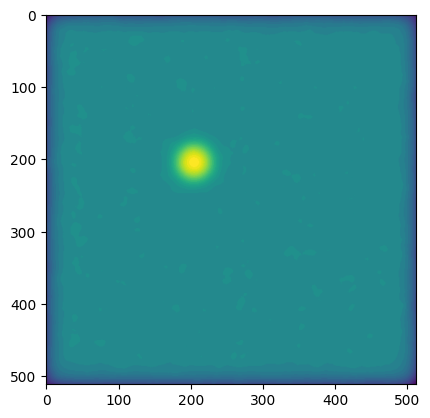

In [18]:
plt.imshow(data[100])

In [8]:
activation_function=nn.Tanh()
x=torch.linspace(-5,5,100,requires_grad=True)
result=activation_function(x)
result.backward(torch.ones_like(x))

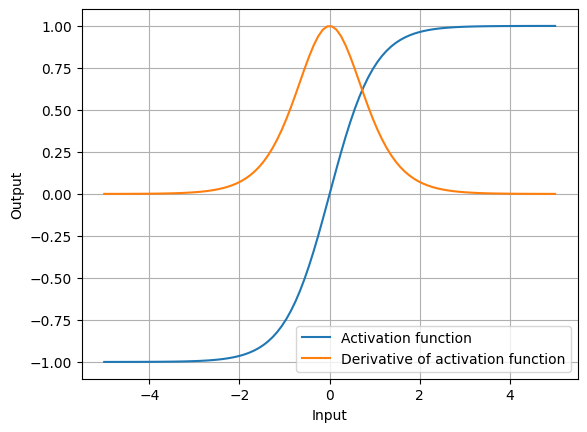

In [9]:
plt.plot(x.detach(),activation_function(x).detach(),label='Activation function')
plt.plot(x.detach(),x.grad.detach(),label='Derivative of activation function')
plt.grid(0.3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()


In [12]:
p_data=data+273.15
p_data=p_data[4:,:,:]
p_data.shape

torch.Size([630, 512, 512])

In [13]:
t = torch.linspace(0, 21, 630)     # shape (630,)
y = torch.linspace(0, 0.1, 512)    # shape (512,)
x = torch.linspace(0, 0.1, 512)    # shape (512,)

t, y, x = torch.meshgrid(t, y, x, indexing='ij')

# We need to concatenate column vectors
coordis = torch.cat([
    t.reshape(-1, 1),
    y.reshape(-1, 1),
    x.reshape(-1, 1)
], dim=1)

print(t.shape)        # (630, 512, 512)
print(coordis.shape)  # (164229120, 3)


torch.Size([630, 512, 512])
torch.Size([165150720, 3])


In [15]:
p_data

tensor([[[293.1500, 293.1500, 293.1500,  ..., 293.1500, 293.1500, 293.1500],
         [293.1500, 293.1500, 293.1500,  ..., 293.1500, 293.1500, 293.1500],
         [293.1500, 293.1500, 293.1500,  ..., 293.1500, 293.1500, 293.1500],
         ...,
         [293.1500, 293.1500, 293.1500,  ..., 293.1500, 293.1500, 293.1500],
         [293.1500, 293.1500, 293.1500,  ..., 293.1500, 293.1500, 293.1500],
         [293.1500, 293.1500, 293.1500,  ..., 293.1500, 293.1500, 293.1500]],

        [[295.3700, 295.3700, 295.3600,  ..., 295.3300, 295.3300, 295.3400],
         [295.3700, 295.3600, 295.3300,  ..., 295.3400, 295.3600, 295.3300],
         [295.3700, 295.3400, 295.2800,  ..., 295.2900, 295.3300, 295.3100],
         ...,
         [295.3200, 295.3100, 295.2900,  ..., 295.1900, 295.3200, 295.3700],
         [295.3300, 295.3600, 295.3600,  ..., 295.3200, 295.3600, 295.3800],
         [295.3300, 295.3300, 295.3300,  ..., 295.3700, 295.3800, 295.3800]],

        [[296.4500, 296.4600, 296.4600,  ...

In [19]:
# Shapes
T = p_data          # temperature data, shape (630, 512, 512)
t = torch.linspace(0, 21, 630)
y = torch.linspace(0, 0.1, 512)
x = torch.linspace(0, 0.1, 512)

# Meshgrid
t, y, x = torch.meshgrid(t, y, x, indexing='ij')

# Create mask of valid points (True = valid, False = corrupted)
mask = torch.ones_like(T, dtype=torch.bool)
mask[:, 150:250, 150:250] = False  # exclude this region

# Apply mask to coordinates and data
t_valid = t[mask]
y_valid = y[mask]
x_valid = x[mask]
T_valid = T[mask]

# Concatenate into coordinate tensor
coordis_valid = torch.stack([t_valid, y_valid, x_valid], dim=1)

print(coordis_valid.shape, T_valid.shape)
# e.g. (≈164M - 6.4M, 3), (≈164M - 6.4M,)

torch.Size([158850720, 3]) torch.Size([158850720])


In [20]:
N_samples = 100000
idx = torch.randperm(coordis_valid.shape[0])[:N_samples]

coordis_sampled = coordis_valid[idx]
T_sampled = T_valid[idx]

In [28]:
T_sampled.max()

tensor(306.5900)

In [29]:
T_sampled.min()

tensor(293.1500)